In [72]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import glob
import cv2

In [73]:
import tensorflow as tf
# from tf import keras

import keras
from keras import layers
import visualkeras
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dropout , Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.models import load_model
from keras import Sequential
from keras.layers import LeakyReLU

## About the Data

The dataset has been taken from kaggle competition "I’m Something of a Painter Myself" which provides Monets and photos with the objective of training on the monet painitng and styling them on the photos. The dataset provided has 2 formats of the same data i.e. '.tfrec' and '.jpeg'. In our scenario, we will be sticking to the jpegs for further work.

The dataset has 300 monets and 7038 photos. The model will be trained using DCGANs.

## Importing Data

In [3]:
monet_rt = "gan-getting-started/monet_jpg/"
photo_rt = "gan-getting-started/photo_jpg/"

In [4]:
monet_data = os.listdir("gan-getting-started/monet_jpg/")
photo_data = os.listdir("gan-getting-started/photo_jpg/")

## Exploratory Data Analysis

In [49]:
len(monet_data)

300

In [50]:
len(photo_data)

7038

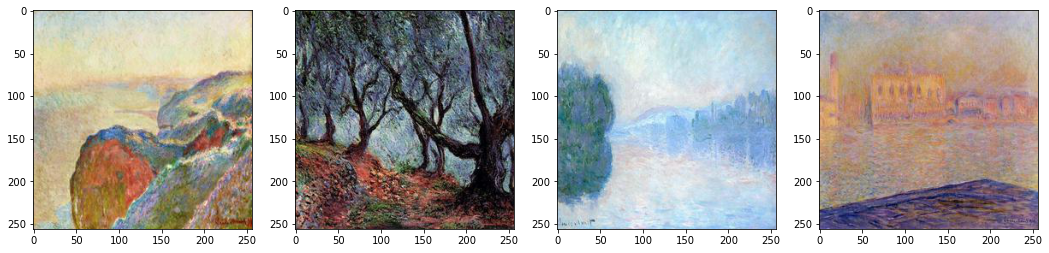

In [7]:
fig , ax = plt.subplots(1,4, figsize = (18,10))
for i in range(4):
    ax[i].imshow(Image.open(monet_rt + monet_data[i]))

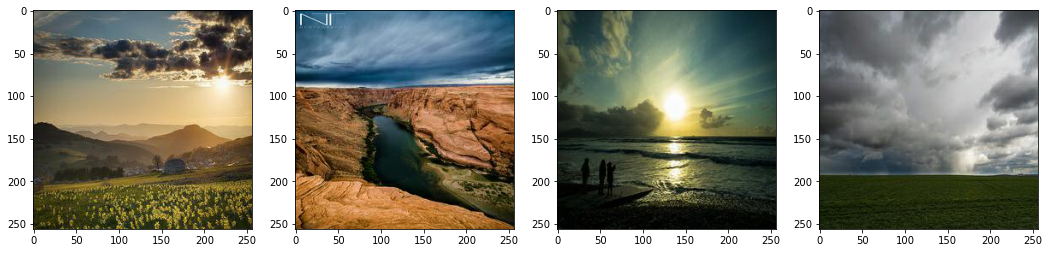

In [8]:
fig , ax = plt.subplots(1,4, figsize = (18,10))
for i in range(4):
    ax[i].imshow(Image.open(photo_rt + photo_data[i]))

### Analysis:

A brief analysis of the images doesn't seem to show anything peculoar or other than the ordinary. They are simply monets which are 300 to train and 7038 photos provided. However, there does seem to be one thing that is clear, that they are all regarding sceneries and they are 256 x 256 pixels.

## Data Preprocessing

In order to put our data into the modelling phase, we need to perform certain prelimanary steps to get the data in the correct form. To this, we perform the following actions:

1. Read each image from the each directory(Monet and Phots)
2. Read the image
3. Resize the image to 64 x 64 from 256 x 256
4. Convert into array using keras
5. Append the list containing the images converted to arrays

### Data Scaling and Augmentation

In [45]:
train_photo_art = []
for directory in glob.glob('gan-getting-started/photo_jpg/'):
    for filename in glob.glob(directory + '/*'):
        image = cv2.imread(filename)
        image = cv2.resize(image, (64, 64))
        image = tf.keras.preprocessing.image.img_to_array(image)
        train_photo_art.append(image)

In [30]:
train_images_art = []
for directory in glob.glob('gan-getting-started/monet_jpg/'):
    for filename in glob.glob(directory + '/*'):
        image = cv2.imread(filename)
        image = cv2.resize(image, (64, 64))
        image = tf.keras.preprocessing.image.img_to_array(image)
        train_images_art.append(image)
        


In [31]:
train_images_art = np.array(train_images_art, dtype="float")
train_images_art = (train_images_art - 127.5) / 127.5

In [32]:
train_images_art.shape

(300, 64, 64, 3)

In [47]:
train_photo_art = np.array(train_photo_art, dtype="float")
train_photo_art = (train_photo_art - 127.5) / 127.5
train_photo_art.shape

(7038, 64, 64, 3)

## Model

We will be designing the model based on Deep Convolutional Generative Adversarial Network which is more commonly known as DCGAN. The model design and execution will be in the following sequence:

1. Image Generator
2. Image Discriminator
3. joining both to form the GAN
4. Generating results

In [33]:
dim = 100

### Generator

We define the image generator to be a sequential model with an initial dense layer which is configured to have the dimensions as 8 x 8 x256. We then have 3 hidden layers with each using a transposed convolution layer with 128 filters each, size and strides set to 2 and with evenly padding around. The final layer is a conv2D layer configured to give an output of 64 x 64 image. The model is compiled with the loss set to binary_crossentropy and optimizer set to Adam. The leakyRelU is also incorporated in each layer to avoid a dead gradient by providing a small arbitrary value for the gradient with the arbitrary value set to 0.3. 

In [34]:
def image_generator():
    gen = Sequential()
    
    # input layer
    gen.add(Dense(8 * 8* 256 , input_shape = (dim,)))
    gen.add(LeakyReLU(0.3))
    
    gen.add(Reshape((8,8,256)))
    
    # First Hidden Layer
    gen.add(Conv2DTranspose(128 , kernel_size = 2, strides = 2 , padding = 'same'))
    gen.add(LeakyReLU(0.3))
    
    # Second Hidden Layer
    gen.add(Conv2DTranspose(128 , kernel_size = 2, strides = 2 , padding = 'same'))
    gen.add(LeakyReLU(0.3))
    
    # Third Hidden Layer
    gen.add(Conv2DTranspose(128 , kernel_size = 2, strides = 2 , padding = 'same'))
    gen.add(LeakyReLU(0.3))
    
    # fourth hidden layer
    gen.add(Conv2D(3, kernel_size = 2 , padding ='same', activation = 'tanh'))
    
    gen.compile(loss = 'binary_crossentropy' , optimizer = Adam(0.0001 , 0.5))
    return gen

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 128)       65664     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 128)      

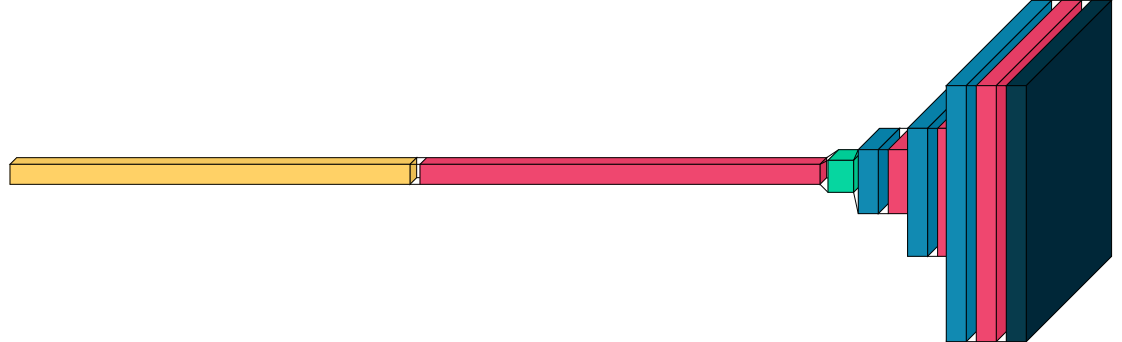

In [35]:
generator = image_generator()
generator.summary()
visualkeras.layered_view(generator)

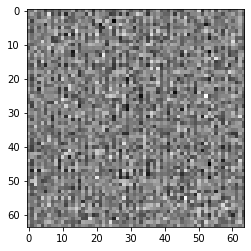

In [36]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Above are two figures depicting the model layers and the output that we get when we give any arbitrary data to the untrained generator.

## Discriminator

The image descriminator is designed to take an input of 64 x 64 image and passes it through 3 hidden layers with the filter 128 and remaining setting as per the conv2Dtranspose. The reason for the majority of the parameters being the same is that that Conv2D and Conv2Dtanspose are simply different approaches for the same problem at hand. Flattening and drop are incorporated to guard against overftitting and to get the final output as a single valye after passing through a dense layer.

In [37]:
def descriminator():
    dis = Sequential()
    
    # Input Layer
    dis.add(Conv2D(64, kernel_size= 2, padding = 'same' , strides = 2  , input_shape=(64, 64, 3)))
    dis.add(layers.LeakyReLU(0.3))
    
    # First Hidden Layer
    dis.add(Conv2D(128 , kernel_size = 2, padding = 'same' , strides = 2 ))
    dis.add(LeakyReLU(alpha = 0.3))
    
    # second hidden layer
    dis.add(Conv2D(128 , kernel_size = 2, padding = 'same' , strides = 2))
    dis.add(LeakyReLU(alpha = 0.3))
    
    # Third Hidden Layer
    dis.add(Conv2D(256 , kernel_size = 2, padding = 'same' , strides = 2))
    dis.add(LeakyReLU(alpha = 0.3))
    
    # Flattening and drops
    dis.add(Flatten())
    dis.add(Dropout(0.2))
    
    # Outplut Layer
    dis.add(Dense(1 , activation = 'sigmoid'))
    
    dis.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0001,0.5))
    return dis

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        832       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       32896     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         65664     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)        

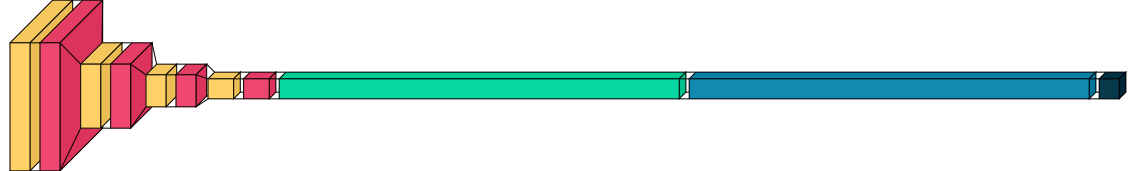

In [38]:
discriminator = descriminator()
discriminator.summary()
visualkeras.layered_view(discriminator)

In [39]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999248]], shape=(1, 1), dtype=float32)


After running the above line of code, we can see that we have a postive value which indicates that our discriminator is declaring the random image that we generated earlier as a valid image which shows that an untrained model is qute despicable.

## Joining the Generator and Discriminator

The following lines of code simply take in the input, reshape it to be compatible with the generator, feeds the input to the generator to generate a fake image and subsequently feeds in the generated fake image to the discrimator. These 2 actions are then combined together to form a gan model with the loss selected to 'cross entropry' and optimizer 'Adam'.

In [41]:
## Joining the Generator and Discriminator to make the model
g_input = tf.keras.Input(shape = (dim,))
fake_image = generator(g_input)
g_output = discriminator(fake_image)

gan = tf.keras.Model(g_input , g_output)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0001, 0.5))

In [42]:
train_images_art.shape

(300, 64, 64, 3)

## Training the Model

In [53]:
batch_size = 16
steps_per_epoch = 100

In [74]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, dim))
save_path = "testers"

dis_loss = []
gen_loss = []

temp_epochs = 20
for epoch in range(temp_epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, dim))
        
        real_images = train_photo_art[np.random.randint(0, train_photo_art.shape[0], size=batch_size)]

        fake_images = generator.predict(noise)

        x = np.concatenate((real_images, fake_images))

        disc = np.zeros(2*batch_size)
        disc[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc)

        gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, gen)
        

        
    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    dis_loss.append(d_loss)
    gen_loss.append(g_loss)
    
    if epoch % 2 == 0:        
        generated_images = generator.predict(noise)
        plt.figure(figsize=(10, 10))

        for i, image in enumerate(generated_images):
            plt.subplot(4, 4, i+1)
            if channels == 1:
                plt.imshow(np.clip(image.reshape((64, 64)), 0.0, 1.0), cmap='gray')
            else:
                image = ((image + 1) / 2)
                plt.imshow(np.clip(image.reshape((64, 64, channels)), 0.0, 1.0))
            plt.axis('off')

        plt.tight_layout()

        if epoch != None:
            plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')

## Results & Analysis

In [59]:
d = {'disc_loss': dis_loss, 'gen_loss': gen_loss}
loss_df = pd.DataFrame(d)
loss_df

,disc_loss,gen_loss
0,0.814604,0.740121
1,0.599983,1.094465
2,0.552478,1.155705
3,0.550455,1.134620
4,0.645463,1.090439
5,0.515290,1.917599
6,0.653593,1.753146
7,0.542564,1.333113
8,0.712700,1.416438
9,0.440260,1.570973


Text(0.5, 1.0, 'loss vs epoch')

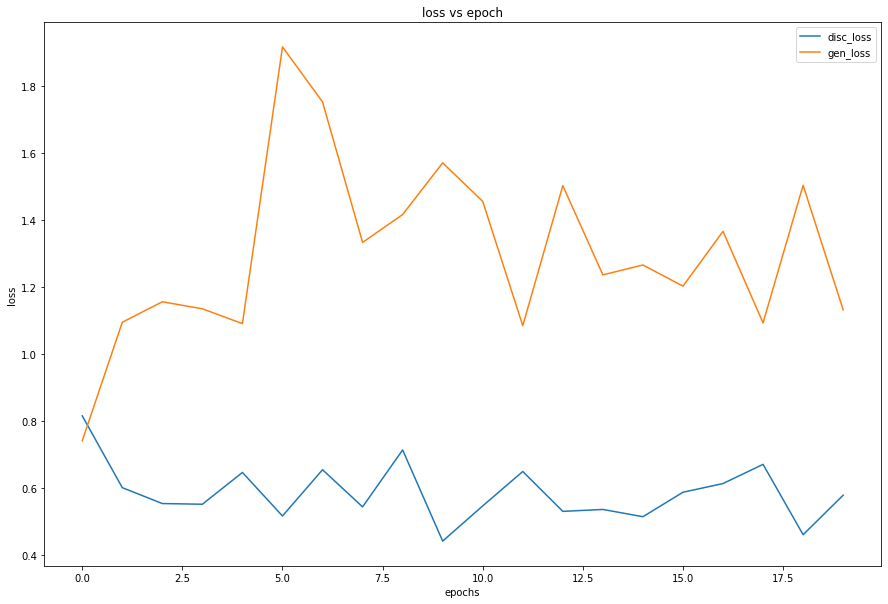

In [71]:
loss_df.plot.line(figsize = (15,10))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epoch')

### Analysis

The graph above depicting the generator and discriminator loss shows that initially both the models are performing close to each other, however, as we increase the epochs, it seems that the discriminator is performing way better than the generator and is able to decipher quite well the images. The images themselver also have not taken a lot of logical shape but only seem to give an outline of the generated sceneries. Though the model was quite basic, it does seem to generate images which depict the shape of a valid scenery though the pixel quality seemingly lacks much clarity.

## Conclusion

The GAN is found to be a very effective tool in generating images which are not real. The most important takeaways from the project include the design of two networks which have opposing roles and design and varying the size of the images during input and during the course of passing the data through the various layers. The network does seem to be improving with the increment in the epochs so a simple increment in the number of epochs might improve the model. Moreover, looking at the losses, the generator seems to be lacking the potential to generate good images, for that it might need some additional layers in its structure to extract the features more effectively. The monet train dataset is also quite small so techniques such as data augmentation might be quite effective as well. 

## References

1. https://rubikscode.net/2018/12/17/implementing-gan-dcgan-with-python/
2. https://keras.io/examples/generative/dcgan_overriding_train_step/
3. https://magenta.tensorflow.org/music-vae
4. https://www.tensorflow.org/tutorials/generative/dcgan
5. https://keras.io/guides/sequential_model/
6. https://keras.io/api/layers/convolution_layers/convolution2d/
7. https://keras.io/api/layers/activation_layers/leaky_relu/
8. https://keras.io/api/layers/convolution_layers/convolution2d_transpose/